In [1]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import math
import statistics
import time
import pytesseract

def strategy_a(document, binary_threshold=200, density_threshold =10):

    start_total_time = time.time()

    doc = cv.imread(document, 0) # 2nd parameter is set to 0 to read grayscale image
    ret, doc_bin = cv.threshold(doc, binary_threshold, 255, cv.THRESH_BINARY)
    doc_bin = 255 - doc_bin #Step 2 Getting negative version of binarised image
  
    num_labels ,labels_im ,stats, centroids = cv.connectedComponentsWithStats(doc_bin) #Step 3 Extract connected components

    #All foreground pixels
    start_time_strat_a = time.time()
    all_foreground_pixels = labels_im
    result_all_foreground_pixels = cv.bitwise_and(doc_bin, doc_bin, mask=all_foreground_pixels.astype(np.uint8))
    end_time_strat_a = time.time()
    strat_a_total_time = end_time_strat_a - start_time_strat_a
    print("Candidate selection time, strategy A took", strat_a_total_time, "seconds")

    cv.imwrite("strat_a_all_foreground.png", result_all_foreground_pixels)

    hough_time, doc_deskewed = hough_deskewer(result_all_foreground_pixels, doc, density_threshold)

    print(f"Hough transform time for strategy A is {hough_time} seconds")

    end_total_time = time.time()
    total_time = end_total_time - start_total_time

    print(f"Total for strategy A is {total_time} seconds")

    return doc_deskewed

def strategy_b(document, binary_threshold=200, density_threshold =10):

    start_total_time = time.time()

    doc = cv.imread(document, 0) # 2nd parameter is set to 0 to read grayscale image
    ret, doc_bin = cv.threshold(doc, binary_threshold, 255, cv.THRESH_BINARY)
    doc_bin = 255 - doc_bin #Step 2 Getting negative version of binarised image

    num_labels ,labels_im ,stats, centroids = cv.connectedComponentsWithStats(doc_bin) #Step 3 Extract connected components

    start_time_strat_b = time.time()
    height, width = np.shape(doc_bin)
    img_mask_centroids = np.zeros((height,width))

    #Ensure centroids are within boundaries
    clipped_centroids = np.clip(centroids, [0,0], [width-1 , height -1 ])

    for item in clipped_centroids[1:]:
        #rounding as need to be ints for assigning a pixel
        x = round(item[0])
        y = round(item[1])
        img_mask_centroids[y, x] = 255

    result_img_centroids = cv.bitwise_and(doc_bin, doc_bin, mask=img_mask_centroids.astype(np.uint8))
    end_time_strat_b = time.time()
    strat_b_total_time = end_time_strat_b - start_time_strat_b

    cv.imwrite("strat_b_centroid.png", result_img_centroids)
    
    print("Candidate selection time, strategy B took", strat_b_total_time, "seconds")
    hough_time, doc_deskewed = hough_deskewer(result_img_centroids, doc, density_threshold)
    print(f"Hough transform time for strategy B is {hough_time} seconds")
    end_total_time = time.time()
    total_time = end_total_time - start_total_time
    print(f"Total for strategy B is {total_time} seconds")
    
    return doc_deskewed

def strategy_c(document, binary_threshold=200, density_threshold =10):

    start_total_time = time.time()

    doc = cv.imread(document, 0) # 2nd parameter is set to 0 to read grayscale image
    ret, doc_bin = cv.threshold(doc, binary_threshold, 255, cv.THRESH_BINARY)
    doc_bin = 255 - doc_bin #Step 2 Getting negative version of binarised image
  
    num_labels ,labels_im ,stats, centroids = cv.connectedComponentsWithStats(doc_bin) #Step 3 Extract connected components

    #Making a blank image with same dimensions
    start_time_strat_c = time.time()
    height, width = np.shape(doc_bin)
    topmost_y_img = np.zeros((height,width))
    topmost_y_coord = []

    for label in range(num_labels):
        #take all the coords where the label is found in the array
        coords = np.argwhere(labels_im == label)
        #skip connected component equal 
        if label == 0:
            continue
        else:
    #take the first one encountered, as we are scrolling by row we should find the topmost y that is to the left
            if coords.size > 0:
                first = coords[0]
                topmost_y_coord.append((label, first[0],first[1]))

    for item in topmost_y_coord:
        topmost_y_img[item[1],item[2]] = 255

    result_img_topmost_y = cv.bitwise_and(doc_bin, doc_bin, mask=topmost_y_img.astype(np.uint8))

    end_time_strat_c = time.time()
    strat_c_total_time = end_time_strat_c - start_time_strat_c
    print("Candidate selection time, strategy C took", strat_c_total_time, "seconds")

    cv.imwrite("strat_c_top_y.png", result_img_topmost_y)
    
    hough_time, doc_deskewed = hough_deskewer(result_img_topmost_y, doc, density_threshold)

    print(f"Hough transform time for strategy C is {hough_time} seconds")

    end_total_time = time.time()
    total_time = end_total_time - start_total_time

    print(f"Total for strategy C is {total_time} seconds")

    return doc_deskewed

In [2]:
def hough_deskewer(document, doc_graph, density_threshold):

    start_time_hough = time.time()

    distance_resolution = 1
    angular_resolution = math.pi/180

    doc_graph_copy = cv.cvtColor(doc_graph, cv.COLOR_GRAY2BGR)

    lines = cv.HoughLines(document, distance_resolution, angular_resolution, density_threshold)
    
    #Step 8 Angles array
    angles = []

    #Check if any lines are detected
    if lines is not None:
        print(f"Number of lines detected: {len(lines)}")
        for rho, theta in lines[:, 0]:
            angles.append(theta)

            #Draw the lines on the image
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv.line(doc_graph_copy, (x1, y1), (x2, y2), (0,0 , 255), 1)
    else:
        print("No lines detected.")

    if angles:
        median_angle = statistics.median(angles)
        median_angle = median_angle - np.pi/2 if (median_angle > np.pi/2) else median_angle + np.pi/2

        # Convert from radian to degrees
        median_angle = math.degrees(median_angle)
        print("Median angle in degrees:", median_angle)

        (h, w) = document.shape[:2]
        center = (w // 2, h // 2)
        M = cv.getRotationMatrix2D(center, median_angle, 1.0)
        doc_deskewed = cv.warpAffine(doc_graph_copy, M, (w, h))

        end_time_hough = time.time()
        hough_total_time  = end_time_hough - start_time_hough
        
        plt.subplot(1, 2, 1)
        plt.imshow(cv.cvtColor(doc_graph_copy, cv.COLOR_BGR2RGB))
        plt.title('Original Image with Detected Lines')
        plt.axis('off')
    
        # Plot the deskewed image
        plt.subplot(1, 2, 2)
        plt.imshow(cv.cvtColor(doc_deskewed, cv.COLOR_BGR2RGB))
        plt.title('Deskewed Image')
        plt.axis('off')
    
        plt.show()

        return hough_total_time, doc_deskewed
    
    else:
        print("No angles to calculate median from.")

        end_time_hough = time.time()

        hough_total_time  = end_time_hough - start_time_hough

        
        return hough_total_time, None  # Or handle as needed



Now running with density threshold 10
Candidate selection time, strategy A took 0.0013589859008789062 seconds
Number of lines detected: 36493
Median angle in degrees: 174.00000233751297


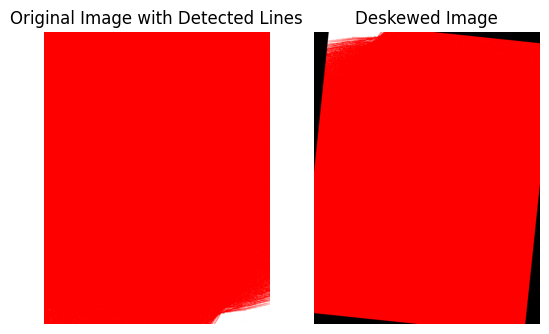

Hough transform time for strategy A is 0.26743125915527344 seconds
Total for strategy A is 0.43527817726135254 seconds

Now running with density threshold 20
Candidate selection time, strategy A took 0.0005309581756591797 seconds
Number of lines detected: 33485
Median angle in degrees: 173.00000117132055


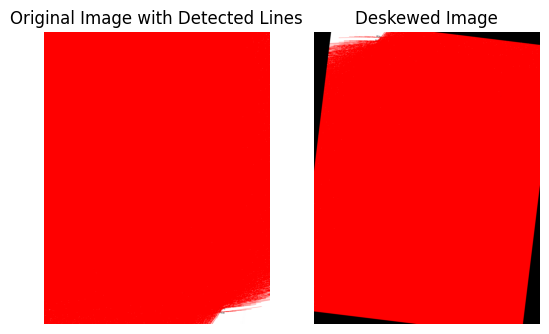

Hough transform time for strategy A is 0.24378299713134766 seconds
Total for strategy A is 0.37861204147338867 seconds

Now running with density threshold 450
Candidate selection time, strategy A took 0.0004658699035644531 seconds
Number of lines detected: 13
Median angle in degrees: 8.9999993398314


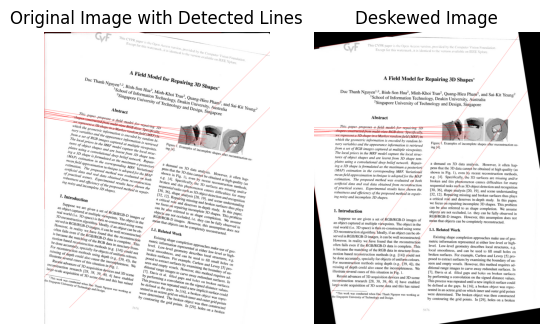

Hough transform time for strategy A is 0.029011011123657227 seconds
Total for strategy A is 0.17954707145690918 seconds


In [3]:
density_threshold_values = [10, 20, 450]

for value in density_threshold_values:
    print()
    print(f"Now running with density threshold {value}")
    doc_result = strategy_a("doc.jpg", binary_threshold=200, density_threshold = value)
    cv.imwrite("strategy_a_deskewing_results.png", doc_result)



Now running with density threshold 5
Candidate selection time, strategy B took 0.010256767272949219 seconds
Number of lines detected: 4167
Median angle in degrees: 176.99999900590097


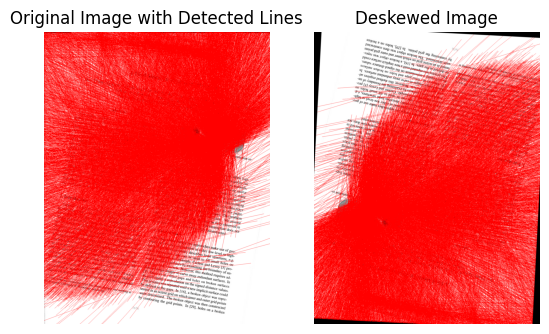

Hough transform time for strategy B is 0.045232295989990234 seconds
Total for strategy B is 0.23643183708190918 seconds

Now running with density threshold 10
Candidate selection time, strategy B took 0.005539894104003906 seconds
Number of lines detected: 208
Median angle in degrees: 148.49999650526894


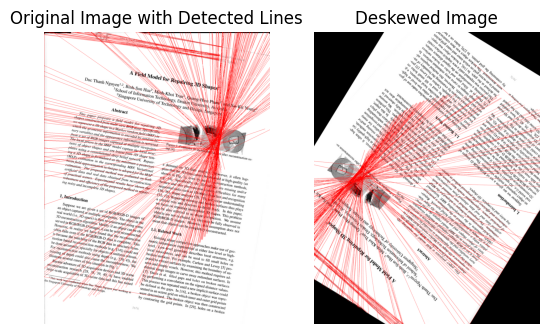

Hough transform time for strategy B is 0.005835056304931641 seconds
Total for strategy B is 0.16723394393920898 seconds

Now running with density threshold 20
Candidate selection time, strategy B took 0.005502939224243164 seconds
Number of lines detected: 3
Median angle in degrees: 10.000000506023795


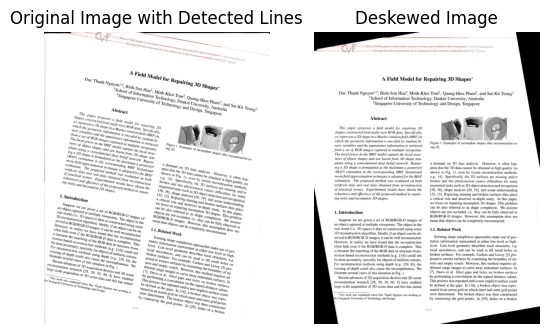

Hough transform time for strategy B is 0.004327058792114258 seconds
Total for strategy B is 0.15552806854248047 seconds


In [4]:
density_threshold_values = [5, 10, 20]

for value in density_threshold_values:
    print()
    print(f"Now running with density threshold {value}")
    doc_result = strategy_b("doc.jpg", binary_threshold=200, density_threshold = value)
    cv.imwrite("strategy_b_deskewing_results.png", doc_result)

#     text = pytesseract.image_to_string(doc_result)
#     print(text)
# else:
#     print("Not deskewed")


Now running with density threshold 5
Candidate selection time, strategy C took 15.673855066299438 seconds
Number of lines detected: 16765
Median angle in degrees: 2.5044781672654152e-06


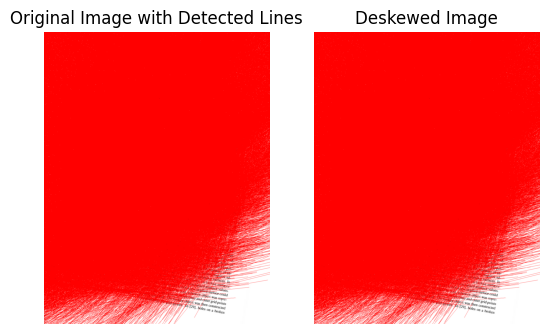

Hough transform time for strategy C is 0.10935711860656738 seconds
Total for strategy C is 15.930867910385132 seconds

Now running with density threshold 10
Candidate selection time, strategy C took 15.452503681182861 seconds
Number of lines detected: 864
Median angle in degrees: 167.49999817235695


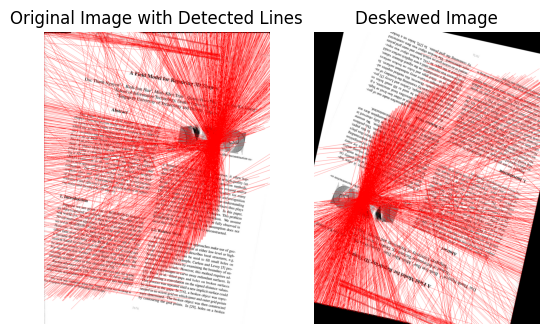

Hough transform time for strategy C is 0.009451866149902344 seconds
Total for strategy C is 15.623484134674072 seconds

Now running with density threshold 20
Candidate selection time, strategy C took 15.753942012786865 seconds
Number of lines detected: 10
Median angle in degrees: 10.000000506023795


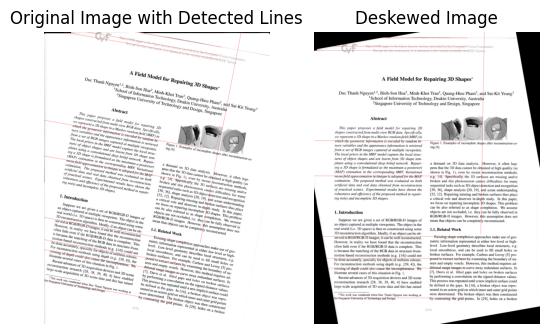

Hough transform time for strategy C is 0.0038559436798095703 seconds
Total for strategy C is 15.905284881591797 seconds


In [5]:
density_threshold_values = [5,10,20]

for value in density_threshold_values:
    print()
    print(f"Now running with density threshold {value}")
    doc_result = strategy_c("doc.jpg", binary_threshold=200, density_threshold = value)
    cv.imwrite("strategy_c_deskewing_results.png", doc_result)



Now running with density threshold 15
Candidate selection time, strategy B took 0.004208803176879883 seconds
Number of lines detected: 9
Median angle in degrees: 45.000000341622666


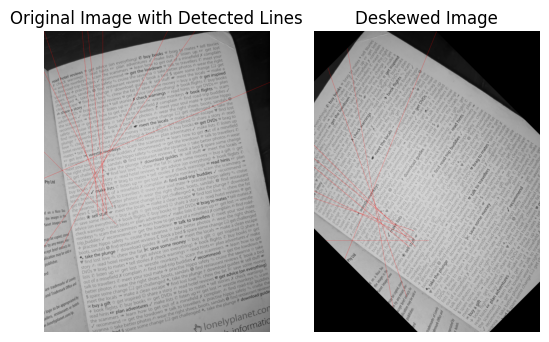

Hough transform time for strategy B is 0.0036590099334716797 seconds
Total for strategy B is 0.1855480670928955 seconds


In [6]:
#Step 3 other images

example1 = cv.imread("example1.jpeg", 0)
example2 = cv.imread("example2.jpeg", 0)
example3 = cv.imread("example3.jpeg", 0)
example4 = cv.imread("example4.jpeg", 0)
example5 = cv.imread("example5.jpeg", 0)

density_threshold_values = [15]

for value in density_threshold_values:
    print()
    print(f"Now running with density threshold {value}")
    doc_result = strategy_b("example1.jpeg", binary_threshold=200, density_threshold = value)
    cv.imwrite("example1_results.png", doc_result)



Candidate selection time, strategy B took 0.007982254028320312 seconds
Number of lines detected: 3
Median angle in degrees: 10.000000506023795


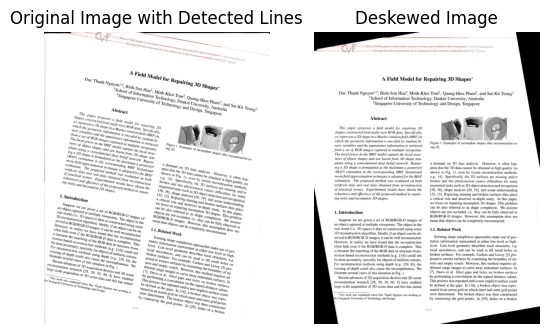

Hough transform time for strategy B is 0.004723072052001953 seconds
Total for strategy B is 0.1869971752166748 seconds
TEXT FOUND IN ORIGINAL DOCUMENT: A Fielg Mode fo Pairing 3D Shapes«
uc Thanh Nguyen! 2. Binh-s a? Mi Oi Tran?
18¢ OO! of J, n

im", and §
leak, Niversit UStralig
log id i

” 28S raised :
Sented in ai

ducted When Due Thanh Neuyen wag Working ap

sity °F Technology and Design.

TEXT FOUND DESKEWED DOCUMENT: A Field Model for Repairing 3D Shapes*

Duc Thanh Nguyen’, Binh-Son Hua’, Minh-Khoi Tran”, Quang-Hieu Pham’, and Sai-Kit Yeung?
1School of Information Technology, Deakin University, Australia
?Singapore University of Technology and Design, Singapore

Abstract

This paper proposes a field model for repairing 3D
shapes constructed from multi-view RGB data. Specifically,
we represent a 3D shape in a Markov random field (MRF) in
which the geometric information is encoded by random bi-
nary variables and the appearance information is retrieved
from a set of RGB images cap

In [7]:
#Step 4
doc_result = strategy_b("doc.jpg", binary_threshold=200, density_threshold = 20)

doc = cv.imread("doc.jpg", 0)

#20 on b is good for doc.jpg
text = pytesseract.image_to_string(doc)
print(f"TEXT FOUND IN ORIGINAL DOCUMENT: {text}" )

text = pytesseract.image_to_string(doc_result)
print(f"TEXT FOUND DESKEWED DOCUMENT: {text}" )


Candidate selection time, strategy B took 0.008229255676269531 seconds
Number of lines detected: 3
Median angle in degrees: 10.000000506023795


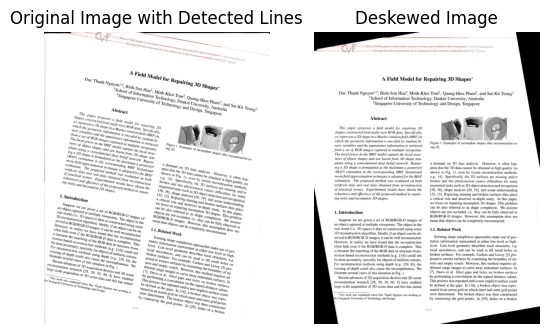

Hough transform time for strategy B is 0.00542902946472168 seconds
Total for strategy B is 0.27144479751586914 seconds
Pdf created at: doc_result1.pdf


In [16]:
def document_recognition_system(document, output_path):

    doc_result = strategy_b(document, binary_threshold=200, density_threshold = 20)
    text = pytesseract.image_to_string(doc_result)
    pdf = pytesseract.image_to_pdf_or_hocr(doc_result, extension='pdf', config='hocr')

    output_pdf_path = output_path
    
    with open('doc_result.pdf', 'w+b') as f:
        f. write(pdf)

    return output_pdf_path, text

pdf_path, text_output = document_recognition_system('doc.jpg', 'doc_result1.pdf')
print(f"Pdf created at: {pdf_path}")

Candidate selection time, strategy B took 0.005772113800048828 seconds
Number of lines detected: 7
Median angle in degrees: 172.00000000512816


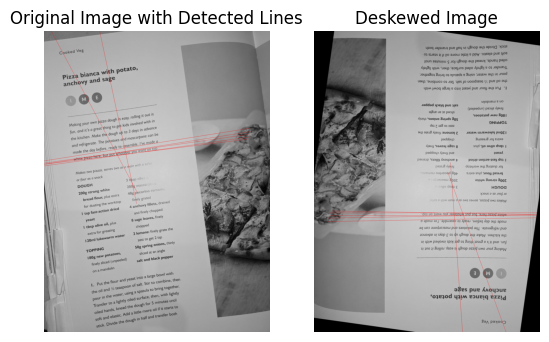

Hough transform time for strategy B is 0.005161762237548828 seconds
Total for strategy B is 0.1839280128479004 seconds
Output After flipping:

Pdf created at: example2results.pdf
Making your own pizza dough js easy, rolling it out is
fun, and it’s a great\thing to get kids involved with in
the kitchen. Make the dough up to 3 days in advance
and refrigerate. The potatoes ahd mascarpone can be

made the day before, re:

ssemble. I've made a

Hatever you want

Makes two pizzas, serves two as
or four as a snack
DOUGH
200g strong white
bread flour, plus extra

for dusting the worktop

| tsp fast-action dried
yeast

I tbsp olive oil, plus
extra for greasing

120ml lukewarm water

4 anchovy fillets, dr

and finely chopped
8 sage leaves, finely
chopped

2 lemons: finely grate the

zest to get 2 tsp
TOPPING
50g spring onions, thinly
180g new potatoes,
sliced at an angle
finely sliced (unpeeled)
salt and black pepper
on a mandolin

1. Put the flour and yeast into a large bowl with
the oil and '4

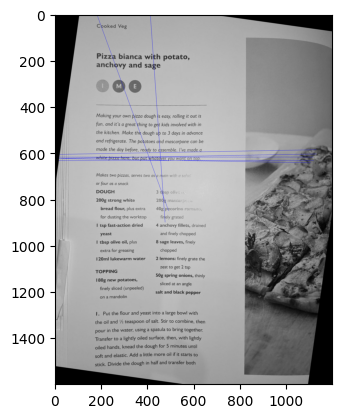

In [28]:
def document_recognition_system(document, output_path):

    doc_result = strategy_b(document, binary_threshold=200, density_threshold = 12)
    doc_result= cv.flip(doc_result,-1)
    print("Output After flipping:")
    print()
    plt.imshow(doc_result)
    text = pytesseract.image_to_string(doc_result)
    pdf = pytesseract.image_to_pdf_or_hocr(doc_result, extension='pdf', config='hocr')

    output_pdf_path = output_path
    
    with open(output_path, 'w+b') as f:
        f. write(pdf)

    return output_pdf_path, text

pdf_path, text_output = document_recognition_system('example2.jpeg', 'example2results.pdf')
print(f"Pdf created at: {pdf_path}")

print(text_output)